## Using Twitter Sentiment to Predict Stock Trends

### Introduction

The idea for this project started in a writing class that I took as a Senior at Brigham Young University. The assignment was to write a 10 page literature review regarding a subject that we were interested in. I love to watch my Robinhood account go up and down with the stock market and after learning so much about machine learning I thought there must be some way to predict the stock market. I began to research different methods of machine learning in stock prediction and surprisingly there were several articles using natural language processing to predict stock fluctuations. One of their primary sources was Twitter. I thought that it would be interesting to try out my new knowledge in machine learning and NLP to perform an analysis similar to the ones that I had been reading. The literature review that I wrote can be found in the https://github.com/andersonb97/RockinRobin repository if you would like to read more regarding my findings.

The purpose of this document is to demonstrate my skills in machine learning and natural language processing. My research question is, "Can tweets about a particular company can be used to predict if that company's stock price will have increased or decreased from the innital opening price by the end of the day?"

This project contains steps and information regarding my analysis including:
* Data Collection
* Cleaning
* EDA
* Variable Creation
* Modeling

### Data Collection

#### Twitter

Twitter data can be pulled using Twitter's API which is readily available to students and for other projects. API access is granted to Twitter users who have applied for developer status. A quick description of the project is required and API keys are granted upon project approval.

To pull the twitter data I used a package called 'Tweepy' which has a couple of shortcomings including that you can only pull tweets from the last week. This limited the amount of data that I was able to obtain significantly because I was limited to three week's worth of data in the time span of my project. I coded my data pull to include the most recent 10,000 for each company in the S&P 500 for a given day. My pull resulted in a Pandas data frame where each row contained:

* Tweet
* Username who tweeted
* Location from which the tweet was made
* Tweet timestamp
* Searchwords

The searchwords used to find each tweet contained the name of the company, the ticker symbol in the US stock exchange, and the modifier "-filter:retweets". The modifier "-filter:retweets" ensured that I didn't get duplicate tweets. An example searchword phrase for Tesla would be "TSLA OR Tesla -filter:retweets". The resulting data frame is then saved as a .csv file. 

Full code for my Twitter data pull is provided in the Github repository: https://github.com/andersonb97/RockinRobin in the file tweetPull.ipynb. 

#### Yahoo! Finance

The financial data necessary for this project was scraped from Yahoo! Finance using the 'read_html()' function in the Pandas package. 
A list of S&P 500 companies with their name and ticker symbol were scraped from Wikipedia (https://en.wikipedia.org/wiki/List_of_S%26P_500_companies). 

Using the resulting ticker symbols I created a scrape using the following form to obtain recent stock data: 

'https://finance.yahoo.com/quote/' + ticker + '/history?p=' + ticker 

- where 'ticker' represents the ticker symbol for a company as a string.

Using the resulting data I created two variables: delta and delta_bin. "delta" is the numeric change between opening and closing price. "delta_bin" is the categorical change in stock price, either "positive" or "negative".

Full code for my Twitter data pull is provided in the Github repository (https://github.com/andersonb97/RockinRobin) in the file stockPull.ipynb. 

#### Import Necessary Packages

In [2]:
import nltk
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.util import ngrams
from os import listdir, getcwd
from collections import Counter
from os.path import isfile, join
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from nltk import wordpunct_tokenize, word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score

#### Read in Data

In [14]:
# Read in stock data.
stocks = pd.read_csv('stockData.csv')

In [15]:
# Get Tweet data files.
onlyfiles = [f for f in listdir(getcwd()) if isfile(join(getcwd(), f))]
# Read and concatenate all twitter data files.
tweets = pd.concat([pd.read_csv(file) for file in [i for i in onlyfiles if 'tweetData' in i]])

### Data Cleaning

#### Clean Stocks Data

The stock data is fairly cleaned based of the pull that I did. During the pull I removed any rows containing strings (stock splits). However, there are some duplicates in the data so it is necessary for me to remove duplicates. In addition, I change the date into a format consistent with the date data that I collected from Twitter

In [16]:
# There are some duplicates that need to be removed in the stock data.
stocks = stocks.drop_duplicates(['ticker', 'Date'])[['ticker', 'Date', 'delta_bin']]

In [17]:
stocks['date'] = [dt.datetime.strptime(i, '%b %d, %Y').strftime('%Y-%m-%d') for i in stocks.Date]
stocks = stocks.drop('Date', 1)

#### Clean Twitter Data

The first step to cleaning twitter data was to rename the columns. Then I need to take out the ticker symbol and drop unnecessary columns. After this brief cleaning the next step is the clean the text of the tweets. To do this I turn the words into lowercase, split the words, and remove stopwords. The stopwords that I use come from the 'english' dictionary in the NLTK package.

The final step in the twitter data cleaning is to combine the text strings for each company each day. So if 20 people tweeted about Tesla on the same day, we concatenate those strings into one string and one data observation for Tesla that day.

In [18]:
# Rename the columns
tweets.columns = ['tweet', 'user', 'location', 'date', 'retweets', 'searchwords']

In [19]:
# Grab the ticker symbol from searchwords
tweets['ticker'] = [i.split(' OR')[0] for i in tweets['searchwords']]

In [20]:
# Drop unnecessary columns
tweets = tweets.drop_duplicates(['tweet', 'date', 'ticker'])[['tweet', 'date', 'ticker']]

In [21]:
# Clean the tweets to remove stopwords and symobols
sw = stopwords.words('english')
def clean_text(x):
    x = x.lower()
    words = x.split()
    words = [w for w in words if w not in sw]
    words = [w for w in words if w.isalpha()]
    return " ".join(words)

tweets['tweet'] = tweets['tweet'].apply(clean_text)

In [22]:
# Create one string from all of the tweets regarding that company on that day.
tweets['date'] = [i.split(' ')[0] for i in tweets['date']]
tweets_grouped = tweets.groupby(['date', 'ticker'])
grouped_lists = tweets_grouped["tweet"].agg(lambda column: " ".join(column))
tweets = grouped_lists.reset_index(name="tweet")

#### Combine Data Frames

With both data frames clean we can combine them into one data frame. This data frame we call dataFinal and it is created using a left merge on 'date' and 'ticker' symbol.

In [23]:
# Merge the DataFrames together to see if tweets from the day affect closing price
dataFinal = tweets.merge(stocks, left_on=['date', 'ticker'], right_on=[ 'date', 'ticker'])

In [24]:
dataFinal.head()

date ticker                                              tweet  \
0  2020-11-16    AAP  highlights annual mobil twelve hours sebring p...   
1  2020-11-16   ANTM  today released legendary anthem empowerment no...   
2  2020-11-16    BLK  years ago michael jordan ridiculous line vs pt...   
3  2020-11-16   CARR  south korean korean air says buy smaller troub...   
4  2020-11-16     CE  great post awhile ago rise nazi hippies worth ...   

  delta_bin  
0      down  
1      down  
2      down  
3        up  
4        up

### EDA

My analysis focuses on two different approaches: Semantic Models and Sentiment Models. This is something that is discussed in the literature review I attached. Because I focus on Semantic and Sentiment models I look into two different points in my exploratory data analysis. For semantic analysis EDA, I look at word counts within the tweets along with bigrams and trigrams. For sentiment analysis, I look more into the sentiment behind the tweets in general regarding the stock market. 

#### Word Counts

Popular words in the tweets collected include 'new', 'walmart' and 'trump'. This really doesn't give us a ton of insight into the tweets other than important names and companies included in the set.

In [25]:
long_content = " ".join(list(dataFinal['tweet'])).split()
c = Counter(long_content)
wc_total = pd.DataFrame(c.items(), columns=['word', 'count'])
wc_total.sort_values(by='count', ascending=False).head(10)

word  count
222       new    150
548   johnson    131
662       key    130
230       cop    124
1188  walmart    104
75       says     91
70      trump     90
15     anthem     85
49     people     84
20        one     83

In [26]:
for_plot = wc_total.sort_values(by='count',ascending=False).head(15)

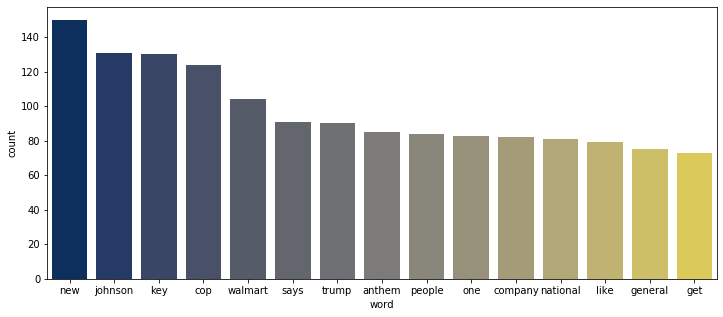

In [27]:
plt.figure(figsize=(12,5))
sns.barplot(x='word', y='count',data=for_plot, palette='cividis')

#### Count bigrams/trigrams

Bigrams and trigrams give us a little more insight into the topics that are commonly discussed in the tweets. Important names of companies and individuals are included in the bigrams while trigrams give us insight into topics discussed. In the bigrams you see names of companies like GM, Tyson, Paypal, and Home Depot. In the trigrams we see topics immerge such as singing the national anthem, army missions, and cashapps.

In [28]:
bigrams = ngrams(long_content, 2)

In [29]:
c2 = Counter(bigrams)

In [30]:
bic = pd.DataFrame(c2.items(), columns=['word','count'])

In [31]:
bic.sort_values(by='count',ascending=False).head(15)

word  count
692     (boris, johnson)     49
533    (general, motors)     41
5389      (tyson, foods)     31
47    (national, anthem)     29
9341     (black, friday)     12
1124        (joe, biden)     12
7303     (many, workers)     12
1382     (paypal, venmo)     11
2276       (home, depot)     11
6107      (motors, says)     11
7304    (workers, would)     11
262         (black, man)     11
1381   (cashapp, paypal)     10
1060     (donald, trump)     10
6036       (hazard, pay)     10

In [32]:
trigrams = ngrams(long_content, 3)
c3 = Counter(trigrams)
pd.DataFrame(c3.items(), columns=['word','count']).sort_values(by='count', ascending=False).head(15)

word  count
7649     (many, workers, would)     11
6380    (general, motors, says)      9
3530        (alpha, phi, alpha)      9
1410    (post, cashapp, paypal)      9
1411   (cashapp, paypal, venmo)      8
1412   (paypal, venmo, bitcoin)      8
47     (sing, national, anthem)      7
2423          (omega, psi, phi)      7
7349       (mission, army, vet)      7
7650      (workers, would, get)      6
12894  (penguin, random, house)      6
14277      (near, today, worth)      6
14276        (nio, near, today)      6
14278   (today, worth, general)      6
14275      (startup, nio, near)      6

#### Sentiment

Sentiment analysis involves assigning sentiment to each word and tweet. The sentiment lexicon that we use is suggested by Mishev et al. (2020) in the publication "Evaluation of Sentiment Analysis in Finance: From Lexicons to Transformers". This article suggests the use of the Loughran McDonald Dictionary for financial data. This dataset includes 86,486 words with 2,355 negatively connotated words, and 354 positively connotated words. 

Based on the EDA performed on general tweet sentiment words such as 'good', 'happy', 'best', and 'win' were very commonly used to indicate positive sentiment. Words such as 'fired', 'breaking', 'accused' and 'lost' are very common negative words.

In [33]:
# Read in sentiments
sentiments = pd.read_csv('LoughranMcDonald_MasterDictionary_2018.csv')
sentiments['word'] = [str(i).lower() for i in sentiments['Word']]
sentiments = sentiments.drop('Word', 1)

In [34]:
sentiments['sentiment'] = ['positive' if int(sentiments['Positive'][i]) > 0 else 'negative' if int(sentiments['Negative'][i]) > 0 else 'neutral' for i in range(len(sentiments['Positive']))]
sentiments = sentiments[['word', 'sentiment']]

In [35]:
new = pd.merge(wc_total, sentiments, how='inner')
new.head()

word  count sentiment
0  highlights      3   neutral
1      annual      5   neutral
2      twelve      2   neutral
3       hours      7   neutral
4   presented      3   neutral

In [36]:
new['sentiment'].value_counts()

neutral     5134
negative     348
positive     100
Name: sentiment, dtype: int64

In [37]:
p = new[new['sentiment']=='positive'].sort_values(by='count',ascending=False).head(10)
n = new[new['sentiment']=='negative'].sort_values(by='count',ascending=False).head(10)

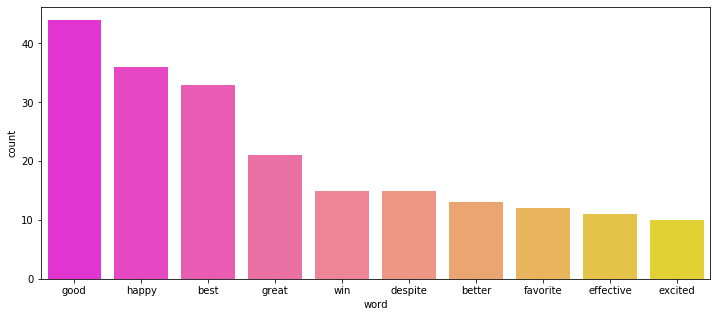

In [38]:
plt.figure(figsize=(12,5))
sns.barplot(x='word', y='count',data=p,palette='spring')

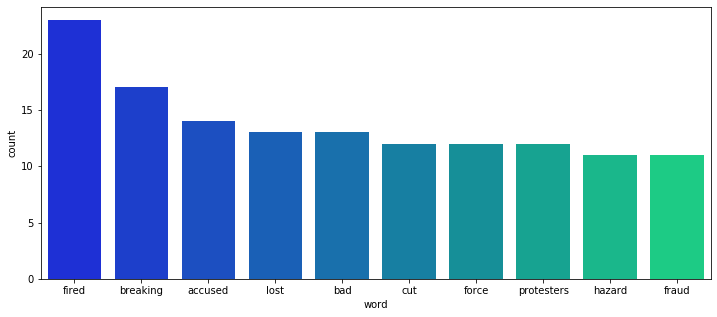

In [39]:
plt.figure(figsize=(12,5))
sns.barplot(x='word', y='count',data=n, palette='winter')

### Feature Creation

The features that I create include TF-IDF scores and Sentiment for each tweet. The TF-IDF scores are created further down when I perform my semantic analyses. However, I generate the sentiment here. I generate two columns containing the positive percentage of words in the tweet and the negative percentage of words in the tweet. 

To generate positive and negative sentiment for each tweet I tokenize the words in each tweet, I then lemmentize the words before a sentiment is created. Using the lemmentized words the percentage of positive words in the tweet are calculated and the percentage of negative words in the tweet are calculated. These two proportions are added into the dataset as 'sent_pos' as 'sent_neg'.

#### Generate Sentiment for each Tweet

In [40]:
def pos_pct(x):
    try:
        pos = x.positive
    except:
        pos = 0
    try:
        neg = x.negative
    except:
        neg = 0
    try:
        neu = x.neutral
    except:
        neu = 0
    try:
        pct_pos = pos / (pos + neg + neu)
    except:
        pct_pos = 0
    return(pct_pos)

def neg_pct(x):
    try:
        pos = x.positive
    except:
        pos = 0
    try:
        neg = x.negative
    except:
        neg = 0
    try:
        neu = x.neutral
    except:
        neu = 0
    try:
        pct_neg = neg / (pos + neg + neu)
    except:
        pct_neg = 0
    return(pct_neg)

In [41]:
wn = WordNetLemmatizer()
def process_text(x):
    x = x.lower()
    tokens = wordpunct_tokenize(x)
    tokens = [tok for tok in tokens if tok.isalnum()]
    tokens = [wn.lemmatize(tok) for tok in tokens]
    return(tokens)

In [42]:
sent_pos = []
for tweet in dataFinal['tweet']:
    c = Counter(process_text(tweet))
    tmp = pd.DataFrame(c.items(), columns=['word','count'])
    tmp = tmp.merge(sentiments, how='inner')
    x = tmp['sentiment'].value_counts()
    sent_pos.append(pos_pct(x))

In [43]:
sent_neg = []
for tweet in dataFinal['tweet']:
    c = Counter(process_text(tweet))
    tmp = pd.DataFrame(c.items(), columns=['word','count'])
    tmp = tmp.merge(sentiments, how='inner')
    x = tmp['sentiment'].value_counts()
    sent_neg.append(neg_pct(x))

In [44]:
dataFinal['sent_pos'] = sent_pos
dataFinal['sent_neg'] = sent_neg

In [45]:
dataFinal.head()

date ticker                                              tweet  \
0  2020-11-16    AAP  highlights annual mobil twelve hours sebring p...   
1  2020-11-16   ANTM  today released legendary anthem empowerment no...   
2  2020-11-16    BLK  years ago michael jordan ridiculous line vs pt...   
3  2020-11-16   CARR  south korean korean air says buy smaller troub...   
4  2020-11-16     CE  great post awhile ago rise nazi hippies worth ...   

  delta_bin  sent_pos  sent_neg  
0      down  0.000000  0.000000  
1      down  0.014085  0.014085  
2      down  0.000000  0.074074  
3        up  0.000000  0.125000  
4        up  0.041667  0.041667

## Methods & Results

I selected semantic and sentiment approaches because they are the two most common approaches to natural languge processing that have been discussed on literature regarding the topic. 

### Semantic Model Approach

A semantic model approach takes into account the frequency of the words used as a proportion of the words in a tweet and in the dataset. A popular way of doing this is using TF-IDF scores. TF-IDF stands for "total frequency-inverse document frequency". Each word in the dataset is assigned a value, calculated based on how often it is used.

First I break the data into testing and training datasets. I use a 70/30 training test split stratified on the categorical change in the price of that stock for that day. I generate TF-IDF scores using the TfidfVectorizer function in the sklearn package in Python. 

Once the TF-IDF scores have been calculated I try classification using a Multinomial Naive Bayes classifier and a Random Forest Classifier. The Multinomial Naive Bayes is a good method for text classificaiton and results in an accuracy of 0.53 and an F1 Score of 0.63. The reason that I selected the Multinomial Naive Bayes estimator is because it doesn't require much training data and is relatively quick compared to other classifiers. It could be used to make almost real time stock market predictions. Unfortunately, one of the main limitations of the Multinomial Naive Bayes classifier is it makes the simplifiying assumption that there is no relationship between variables. The results from the Multinomial Naive Bayes estimator are very similar to the results obtained using the Random Forest classifier which produces an accuracy of 0.56 and an F1 score of 0.64. The reason I chose to use a Random Forest is because it has historically handled classification problems very well. This is because it relies on multiple iterations and decision trees to get the most accurate prediction. The Random Forest model does have weaknesses, including that they are not very interpretable and tend to overfit. However, based on the confusion matrix it seems there is no evidence of overfitting.

In [111]:
train, test = train_test_split(dataFinal, 
                               test_size=.3,
                               stratify=dataFinal.delta_bin, 
                               random_state=123)

In [112]:
y_train = (train['delta_bin'] == 'up').astype(int)
y_test = (test['delta_bin'] == 'up').astype(int)

#### Generate TF-IDF Features

In [113]:
tfidf = TfidfVectorizer(max_df = 0.95)

In [114]:
tfidf.fit(train['tweet'])
X_train = tfidf.transform(train['tweet'])
X_test = tfidf.transform(test['tweet'])

#### Multinomial Naive Bayes

In [115]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
yhat_test = nb.predict(X_test)
confusion_matrix(y_test, yhat_test)

array([[28, 58],
       [27, 68]], dtype=int64)

In [116]:
accuracy_score(y_test, yhat_test)

0.5303867403314917

In [117]:
f1_score(y_test, yhat_test)

0.6153846153846154

In [118]:
precision_score(y_test, yhat_test)

0.5396825396825397

#### Random Forest

In [119]:
rf = RandomForestClassifier(100)
rf.fit(X_train, y_train)
yhat = rf.predict(X_test)
confusion_matrix(y_test, yhat)

array([[30, 56],
       [24, 71]], dtype=int64)

In [120]:
accuracy_score(y_test, yhat)

0.5580110497237569

In [121]:
f1_score(y_test, yhat)

0.6396396396396397

In [122]:
precision_score(y_test, yhat)

0.5590551181102362

### Sentiment Analysis Approach

Using the sentiments created in the Feature Creation section, I perform two different analyses using a Logistic Regression approach and a Random Forest Classifier. 

Again I break my data into a 70/30 train test split stratified on binary increases or decreases in stock price changes for that company on a given day. The Logistic Regression apporach was unsuccessful in it's classification becasue it only predicted increases in stock market price. This resulted in an accuracy of 0.52 and an F1 Score of 0.69 percent. The reason I chose to use a logistic regression model is because it is one of the most basic models for classification and I thought that it might perform well because there aren't very many explanatory variables to deal with. However, Logistic Regression requires a large amount of data which I do not have and that is one weakness of the model. The Random Forest predicted an accuracy of 0.49, just at the accuracy of chance classification, and an F1 Score of 0.58. I chose to use the Random Forest because it performed well in the semantic analysis and because it generally performs well. The weakensses of the Random Forest are outlined above.

In [140]:
train, test = train_test_split(dataFinal, 
                               test_size=.3,
                               stratify=dataFinal.delta_bin, 
                               random_state=123)

In [141]:
X_train = train[['sent_pos', 'sent_neg']]
X_test = test[['sent_pos', 'sent_neg']]

In [142]:
y_train = (train['delta_bin'] == 'up').astype(int)
y_test = (test['delta_bin'] == 'up').astype(int)

#### Logistic Regression Using Sentiment

In [143]:
lm = LogisticRegression(solver='liblinear', random_state=123)
lm.fit(X_train, y_train)
yhat = lm.predict(X_test)
confusion_matrix(y_test, yhat)

array([[ 0, 86],
       [ 0, 95]], dtype=int64)

In [127]:
accuracy_score(y_test, yhat)

0.5248618784530387

In [128]:
f1_score(y_test, yhat)

0.6884057971014492

In [129]:
precision_score(y_test, yhat)

0.5248618784530387

#### Random Forest Using Sentiment

In [144]:
rf = RandomForestClassifier(100)
rf.fit(X_train, y_train)
yhat = rf.predict(X_test)
confusion_matrix(y_test, yhat)

array([[24, 62],
       [30, 65]], dtype=int64)

In [145]:
accuracy_score(y_test, yhat)

0.49171270718232046

In [146]:
f1_score(y_test, yhat)

0.5855855855855856

In [150]:
precision_score(y_test, yhat)

0.5118110236220472

### Explaination and Results

The steps that I took to improve my predictions can be seen in three different aspects of this report. First, cleaning the text was an important step. I removed unwanted and insignificant words as well as lemmentized the words so that the TF-IDF and sentiment metrics would give more accurate insight into the data. Then I tried a semantic approach and a sentiment approach. Within each of these approaches, I tried two different machine learning models. In addition, I tried a ensemble method (not included in this write up) that did not out-perform either method. The Random Forest outperformed my first attempt in both semantic and sentiment approaches. While none of the models performed well, there is promise that natural language processing of tweets can predict the change in the stock price of a company. 

The model performance metrics that I chose to use were Accuracy, F1 Score, and Precision. 

* Accuracy - The number of correct predictions over the number of total predictions.
* F1 Score - The number of true positives divided by the number of true positives times one-half false positives plus false negatives.
* Precision - The number of correct positives over the number of total positives. 

I chose these methods because they are standard across the machine learning industry and give a good view of the strengths and weaknesses of the model.

The methods and models that I tried do not predict the closing price of specific stocks well. However, as a general trend the semantic methods outperformed the sentiment methods. Of the two semantic methods the Random Forest model performed the best. The semantic models both performed slighly better than chance and indicate that there could be a relationship between tweets and stock performance. The sentiment models on the other hand did not perform well. In fact, the Random Forest did not perform any better than chance based off it's accuracy metric. The Logistic Regression method did not perform well, while it's F1 Score is high, the confusion matrix indicates that the model always predicted an increase in stock price. This is not a viable way to perform an analysis and is not good for long term prediction. 

#### Based off the results of the semantic analyses, tweets can be used to predict changes in stock price. However, futher research with more data should be considered to draw a more conclusive result.

## Conclusion

Answering the question of whether tweets can predict fluctuations in the stock market is a difficult task. It involves gathering data from the Twitter server and scraping stock data from the web. Once the data has been cleaned and collected, exploratory data analysis reveiled trends in the data such as prominent names, current event topics, and company names. I also was able to get a grasp of what positive and negative words were commonly used.

At the conclusion of the EDA I created sentiment features for the positive and negative sentiment contained within a tweet. Using this method and the TF-IDF features I ran semantic and sentiment analyses to classify increases or decreases in stock price. Neither of the methods produced results with a high degree of prediction accuracy. However, there is promise in the results provided by the semantic models. The semantic models slightly outperformed the accuracy of chance which leads me to conclude that given additional research and study relationships could be amplified to produce greater prediction accuracy. 

One weakness of my analysis shows in the results provided by the Logistic Regression analysis. The Logisitc Regression predicted only increases. This is likely due to the relatively small size of the dataset. Given the limited time to pull tweets (3 weeks) the data was sparse. Had I had more time, I would have pulled more tweets from subsequent weeks to increase the amount of data and hopefully the accuracy of the model. I think that one source of bias that I would fix given more time would be improving the searchwords used to find tweets. I would expand the searchwords to include names of company executives as well as other ways of referring to a company (ex. Apple instead of Apple Inc.). 

There are lots of fields of research that could be explored on this topic. However, one of particular interest to me is adding general public mood to the analysis. In the literature review file that I have attached I discuss how sentiment models perform well when predicting the aggregrate rise and fall of the stock market. This general mood could be added in as a feature to this model in addition TF-IDF scores. There are many reasons why someone invests or sells and knowing the general mood of the public could add to the predictability of these models. In addition, current events have also been proven a good indicator of aggregate stock market changes and could be an interesting factor to encorporate for predicting individual stocks.
